In [11]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from reports.report_utils import load_mlruns

plt.style.use("seaborn-v0_8-white")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import mlflow

mlflow.set_tracking_uri("../../mlruns")
def load_mlruns(filter_string="", columns=None, compute_duration=True):
    experiments = mlflow.search_experiments()
    experiment_ids = [experiment.experiment_id for experiment in experiments]
    all_runs = mlflow.search_runs(experiment_ids, filter_string)
    runs = all_runs.copy() if columns is None else all_runs[columns].copy()
    if compute_duration:
        runs["duration"] = (
            all_runs["end_time"] - all_runs["start_time"]
        ).dt.total_seconds()
    runs.dropna(inplace=True)
    return runs


git_commit_hash = "e5a549864be437363e7a08943253b2674848464f"
runs = load_mlruns(
    f"tags.`mlflow.source.git.commit` = '{git_commit_hash}'",
    ["params.model", "metrics.winkler_val", "metrics.coverage_val"],
)
runs.head()

,params.model,metrics.winkler_val,metrics.coverage_val,duration
0,QuantileLightGBM,3.465325,0.893232,1.512
1,QuantileLightGBM,3.446868,0.885137,1.638
2,QuantileLightGBM,3.451480,0.891798,1.381
3,QuantileLightGBM,3.477819,0.877458,4.917
4,QuantileLightGBM,3.458677,0.892400,1.509


/tmp/ipykernel_215201/691967552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Validation coverage"] = df["metrics.coverage_val"].apply(


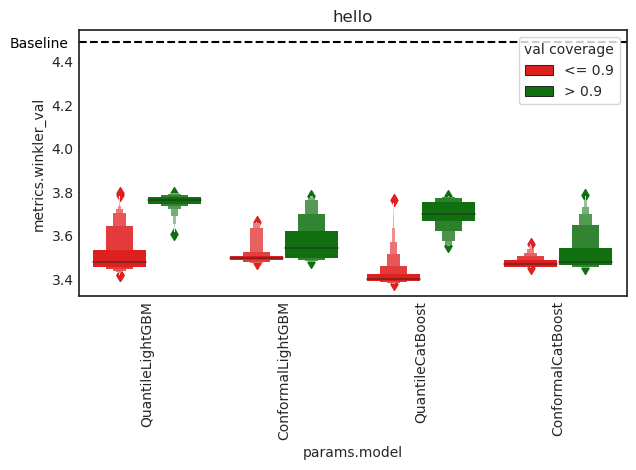

In [36]:
def make_winkler_boxenplot(df, x_col, distinguish_covered=False, title="", save_path=None):
    plt.figure()
    df["Validation coverage"] = df["metrics.coverage_val"].apply(
        lambda x: "> 0.9" if x > 0.9 else "<= 0.9"
    )
    sns.boxenplot(
        x=x_col,
        y="metrics.winkler_val",
        hue="Validation coverage",
        data=df,
        palette={"> 0.9": "green", "<= 0.9": "red"},
        dodge=True
    )
    plt.legend(title="val coverage", loc="upper right", frameon=True)

    baseline = 4.49
    plt.text(x=-1, y=baseline - .025, s="Baseline", color="black")
    plt.axhline(baseline, color="black", linestyle="--")

    plt.xticks(rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()


make_winkler_boxenplot(
    df=runs[runs["metrics.winkler_val"] < 3.8],
    x_col="params.model",
    distinguish_covered=True,
    title="hello",
    save_path="figures/boxplot_winkler_val.png",
)

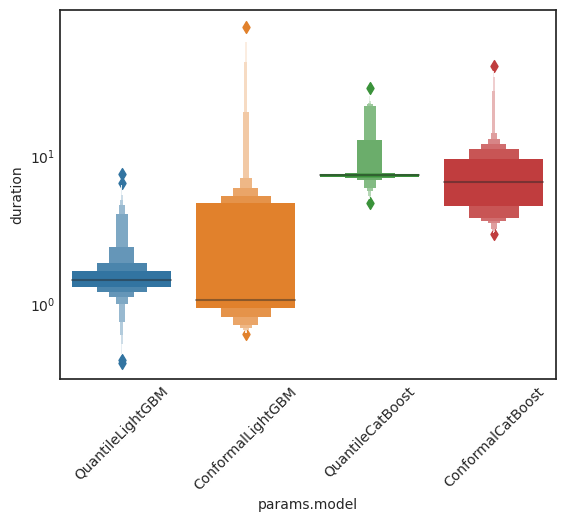

In [140]:
def make_duration_boxenplot(df, x_col, title="", save_path=None):
    plt.figure()
    sns.boxenplot(
        x=x_col,
        y="duration",
        data=df
    )
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yscale("log")
    plt.savefig(save_path, bbox_inches="tight")
    plt.close()

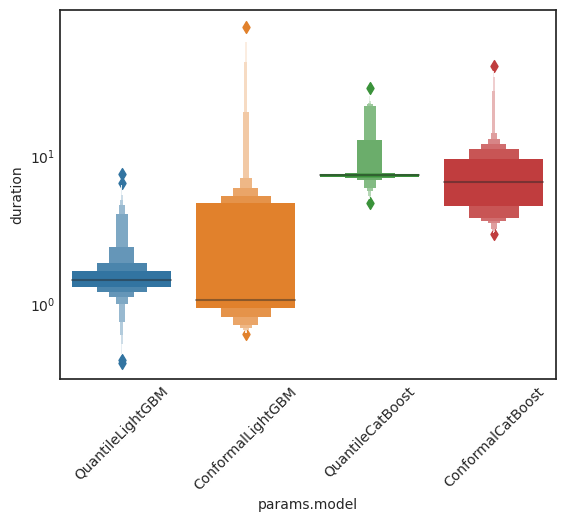

In [139]:
plt.figure()
sns.boxenplot(
    x="params.model",
    y="duration",
    # data=runs[(runs["metrics.winkler_val"] < 3.8) & (runs["duration"] < 50)],
    data=runs[runs["metrics.winkler_val"] < 3.8],
    order=runs['params.model'].unique()
)
plt.xticks(rotation=45)
plt.yscale("log")
plt.show()